# Tugas Kecil IF3170 Inteligensi Buatan

Anggota Kelompok:
1. Kevin John Wesley Hutabarat (13521042)
2. Jericho Russel Sebastian (13521107)

In [1]:
from abc import ABC, abstractmethod

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fmt

In [2]:
# Pembacaan data
data = pd.read_csv("data/data_train.csv")
data.columns = data.columns.str.strip()

In [3]:
# Ukuran data
data.shape

(1400, 21)

In [4]:
# Head data
data.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0


In [5]:
# Definisi kelas-kelas pembantu
STATS_VERTICAL_VIEW = True
ROUNDING_LIMIT = 3
BUCKET_COUNT = 15
XTICK_FORMAT = '%.2f'

class BaseStatistics(ABC):
    def __init__(self, col_name: str) -> None:
        self.col = data[col_name]
        self.std = self.col.std()
        self.var = self.col.var()
        self.max = self.col.max()
        self.min = self.col.min()
        self.mean = self.col.mean()
        self.median = self.col.median()
        self.mode = self._calc_mode()
        self.q4 = [q for q in self.col.quantile([.25, .5, .75]).to_list()]
    
    def range(self) -> float:
        return self.max - self.min
    
    def iqr(self) -> float:
        return self.q4[2] - self.q4[0]
    
    def stats(self) -> pd.DataFrame:
        return pd.DataFrame({
            'Name': ['Mean', 'Median', 'Mode', 'Standard deviation', 'Variance', 'Range', 'Minimum value', 'Maximum value', 'Q1', 'Q2', 'Q3', 'IQR'],
            'Value': [round(self.mean, ROUNDING_LIMIT), self.median, self.mode, round(self.std, ROUNDING_LIMIT), round(self.var, ROUNDING_LIMIT), round(self.range(), ROUNDING_LIMIT), self.min, self.max, round(self.q4[0], ROUNDING_LIMIT), round(self.q4[1], ROUNDING_LIMIT), round(self.q4[2], ROUNDING_LIMIT), round(self.iqr(), ROUNDING_LIMIT)]
        }) if STATS_VERTICAL_VIEW else pd.DataFrame({
            'Mean': [round(self.mean, ROUNDING_LIMIT)],
            'Median': [self.median],
            'Mode': [self.mode],
            'Standard deviation': [round(self.std, ROUNDING_LIMIT)],
            'Variance': [round(self.var, ROUNDING_LIMIT)],
            'Range': [round(self.range(), ROUNDING_LIMIT)],
            'Minimum value': [self.min],
            'Maximum value': [self.max],
            'Q1': round(self.q4[0], ROUNDING_LIMIT),
            'Q2': round(self.q4[1], ROUNDING_LIMIT),
            'Q3': round(self.q4[2], ROUNDING_LIMIT),
            'IQR': round(self.iqr(), ROUNDING_LIMIT)
        })

    def count(self, pred) -> int:
        count = 0
        for x in self.col:
            if pred(x): count += 1
        return count

    def count_zeroes(self) -> int:
        return self.count(lambda x: x == 0)

    def count_outliers(self) -> int:
        r_min, r_max = max(self.min, self.q4[0] - 1.5 * self.iqr()), min(self.max, self.q4[2] + 1.5 * self.iqr())
        return self.count(lambda x: not (r_min <= x <= r_max))

    def versus(self, other: pd.Series):
        return self.col.corr(other), plt.scatter(x=self.col, y=other)
    
    @abstractmethod
    def visualize(self) -> None:
        pass

    @abstractmethod
    def _calc_mode(self) -> float:
        pass

    def __repr__(self) -> str:
        return (
            f'Mean = {round(self.mean, ROUNDING_LIMIT)}\n'
            f'Median = {self.median}\n'
            f'Mode = {self.mode}\n'
            f'Standard deviation = {round(self.std, ROUNDING_LIMIT)}\n'
            f'Variance = {round(self.var, ROUNDING_LIMIT)}\n'
            f'Range = {round(self.range(), ROUNDING_LIMIT)}\n'
            f'Minimum value = {self.min}\n'
            f'Maximum value = {self.max}'
        )


In [6]:
class NumericStatistics(BaseStatistics):
    def __init__(self, col_name: str) -> None:
        super().__init__(col_name)
        self.skew = self.col.skew()
        self.kurt = self.col.kurt()
    
    def stats(self) -> pd.DataFrame:
        stats_df = super().stats()
        if STATS_VERTICAL_VIEW:
            stats_df.loc[len(stats_df.index)] = ['Skewness', round(self.skew, ROUNDING_LIMIT)]
            stats_df.loc[len(stats_df.index)] = ['Kurtosis', round(self.kurt, ROUNDING_LIMIT)]
        else:
            row = stats_df.loc[0].to_dict()
            row['Skewness'] = [round(self.skew, ROUNDING_LIMIT)]
            row['Kurtosis'] = [round(self.kurt, ROUNDING_LIMIT)]
            stats_df = pd.DataFrame(row)
        return stats_df
    
    def kurt_analyze(self):
        print(f'Kurtosis: {self.kurt}')
    
    def visualize_n(self, bucket_count) -> None: #plot
        fig, axs = plt.subplots(2, 1)
        fig.set_size_inches(12,8)

        bucket_width = (self.max - self.min) / bucket_count

        #Histogram
        bucket_bounds = [(self.min + i * bucket_width) for i in range(bucket_count + 1)]
        _, bins, _ = axs[0].hist(self.col, bins=bucket_bounds, edgecolor='white')
        axs[0].set_xticks(bins)
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
        axs[0].xaxis.set_major_formatter(fmt(XTICK_FORMAT))

        #Boxplot
        _ = axs[1].boxplot(self.col, vert=False)
        axs[1].xaxis.set_major_formatter(fmt(XTICK_FORMAT))
    
    def visualize(self) -> None: #plot
        self.visualize_n(BUCKET_COUNT)

    def _create_group_table(self, bucket_count):
        bucket_width = (self.max - self.min) / bucket_count #Panjang kelas
        temp = [[] for _ in range(bucket_count)] #Inisialisasi tabel pengelompokan data

        #Assign nilai sesuai dengan kelompoknya
        for d in self.col.to_list():
            idx = int((d - self.min) / bucket_width)
            if idx == bucket_count: 
                idx -= 1
            temp[idx].append(d)
            
        return temp, bucket_width

    def _create_freq_table(self, bucket_count) -> None:
        #Inisialisasi tabel pengelompokan data
        tempg, bucket_width = self._create_group_table(bucket_count)
        freq_table = [len(x) for x in tempg] #Membuat tabel frekuensi
        return freq_table, bucket_width
    
    def _calc_mode(self) -> float:
        temp = self.col.mode().to_list()
        if len(temp) == 1: return temp[0]

        #Inisialisasi tabel frekuensi
        self.freq_table, bucket_width = self._create_freq_table(self.col.count())

        idx = self.freq_table.index(max(self.freq_table)) #Mengambil indeks dengan frekuensi terbesar
        l = (self.col.min() + idx * bucket_width) #tepi bawah kelas modus
        d1 = 0 if idx == 0 else self.freq_table[idx] - self.freq_table[idx - 1] #selisih frekuensi kelas modus dengan frekuensi kelas sebelumnya
        d2 = 0 if idx == self.col.count() - 1 else self.freq_table[idx] - self.freq_table[idx + 1] #selisih frekuensi kelas modus dengan frekuensi kelas setelahnya
        
        mode = l + bucket_width * d1 / (d1 + d2) #Menghitung modus
        return mode

    def __repr__(self) -> str:
        return (
            f'{super().__repr__()}\n'
            f'Quartile = {[round(q, ROUNDING_LIMIT) for q in self.q4]}\n'
            f'IQR = {round(self.iqr(), ROUNDING_LIMIT)}\n'
            f'Skewness = {round(self.skew, ROUNDING_LIMIT)}\n'
            f'Kurtosis = {round(self.kurt, ROUNDING_LIMIT)}'
        )

In [7]:
class NonnumericStatistics(BaseStatistics):
    def visualize(self) -> None: #histogram
        fig, ax = plt.subplots()
        fig.set_size_inches(8,3)

        _, _, _ = ax.hist(self.col, bins=[(self.min - .5 + i) for i in range(len(self.freq_table) + 1)], edgecolor='white')
        ax.set_xticks([k for k in self.freq_table.keys()])

    def _calc_mode(self) -> float:
        self.freq_table = {}
        for d in self.col.to_list():
            if d in self.freq_table.keys():
                self.freq_table[d] += 1
            else:
                self.freq_table[d] = 1
        (curr_mode, max_f) = (None, -1)
        for d in self.freq_table:
            if self.freq_table[d] > max_f:
                (curr_mode, max_f) = (d, self.freq_table[d])
        return curr_mode

## Analisis Data

In [8]:
# Duplicate value
dup = data.duplicated().to_list()
count = 0
for x in dup:
    if x: count += 1
f'Banyak row duplikat: {count}'

'Banyak row duplikat: 0'

### Battery Power

In [9]:
# Statistik dasar
col = NumericStatistics('battery_power')
col.stats()

,Name,Value
0,Mean,1237.146000
1,Median,1219.000000
2,Mode,825.576818
3,Standard deviation,430.052000
4,Variance,184944.538000
5,Range,1497.000000
6,Minimum value,501.000000
7,Maximum value,1998.000000
8,Q1,864.750000
9,Q2,1219.000000


In [10]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [11]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


Kurtosis: -1.1680683536883105


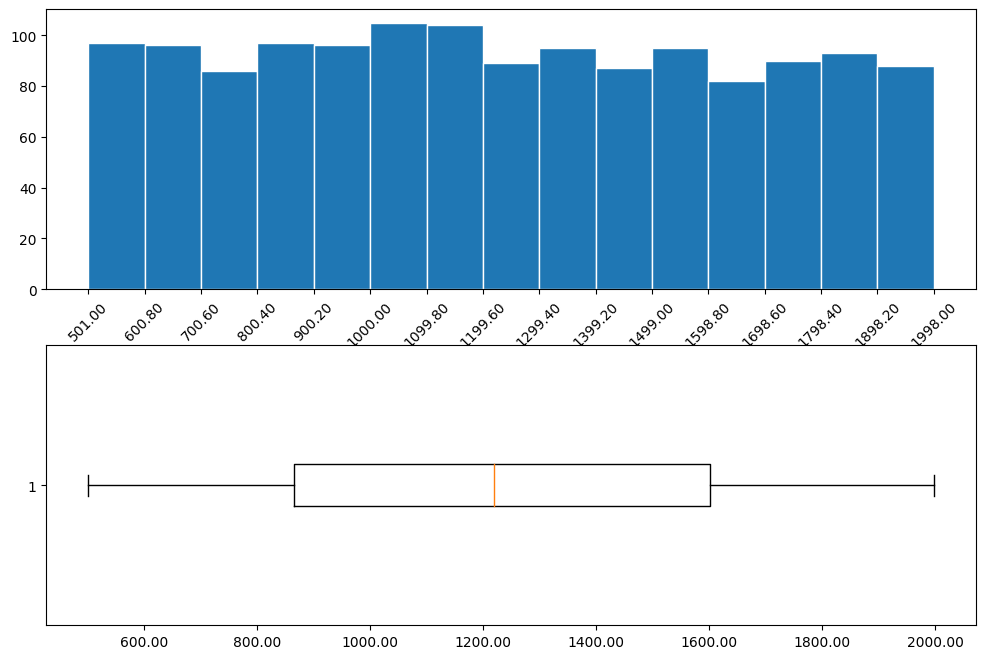

In [12]:
# Distribusi data
col.kurt_analyze()
col.visualize()

Korelasi terhadap target: 0.18480092449553107


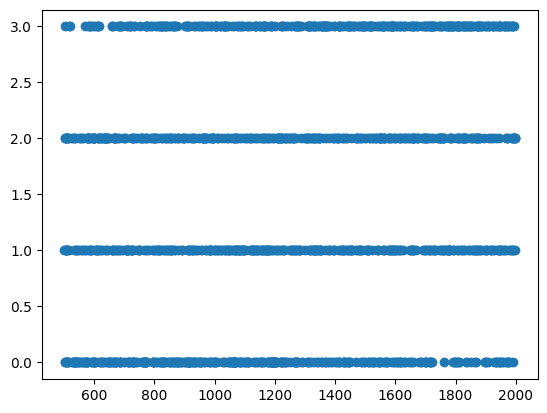

In [13]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Blue

In [14]:
# Statistik dasar
col = NonnumericStatistics('blue')
col.stats()

,Name,Value
0,Mean,0.494
1,Median,0.000
2,Mode,0.000
3,Standard deviation,0.500
4,Variance,0.250
5,Range,1.000
6,Minimum value,0.000
7,Maximum value,1.000
8,Q1,0.000
9,Q2,0.000


In [15]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


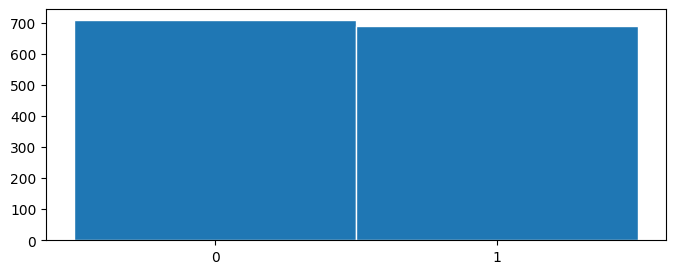

In [16]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.04194688860741444


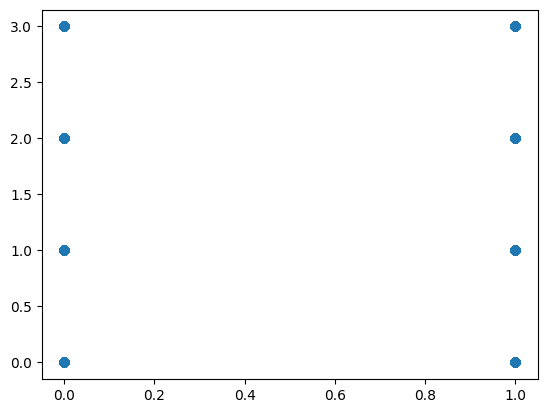

In [17]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Clock Speed

In [18]:
# Statistik dasar
col = NumericStatistics('clock_speed')
col.stats()

,Name,Value
0,Mean,1.522
1,Median,1.500
2,Mode,0.500
3,Standard deviation,0.815
4,Variance,0.664
5,Range,2.500
6,Minimum value,0.500
7,Maximum value,3.000
8,Q1,0.700
9,Q2,1.500


In [19]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [20]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


Kurtosis: -1.3295231896521231


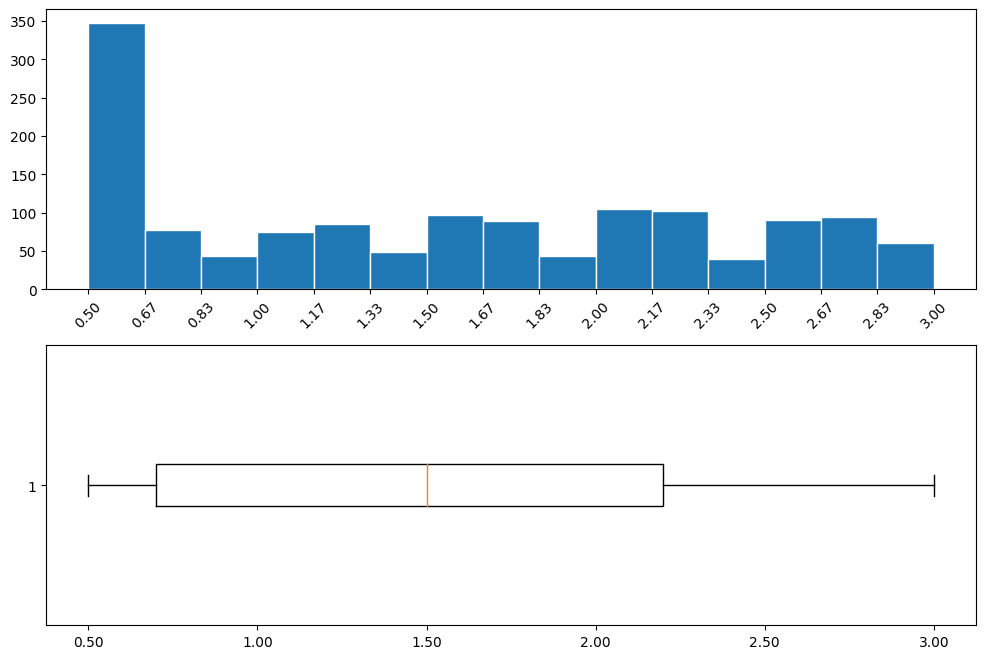

In [21]:
# Distribusi data
col.kurt_analyze()
col.visualize()

Korelasi terhadap target: 0.014031254818008081


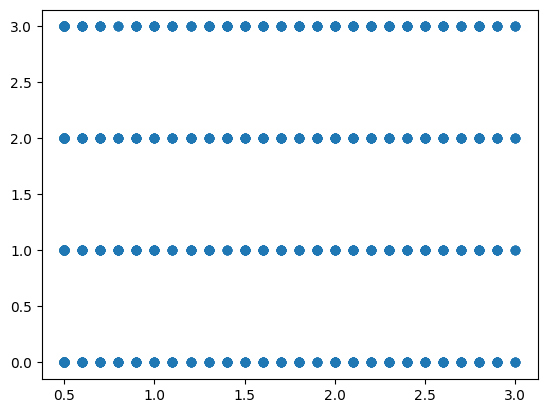

In [22]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Dual SIM

In [23]:
# Statistik dasar
col = NonnumericStatistics('dual_sim')
col.stats()

,Name,Value
0,Mean,0.503
1,Median,1.000
2,Mode,1.000
3,Standard deviation,0.500
4,Variance,0.250
5,Range,1.000
6,Minimum value,0.000
7,Maximum value,1.000
8,Q1,0.000
9,Q2,1.000


In [24]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


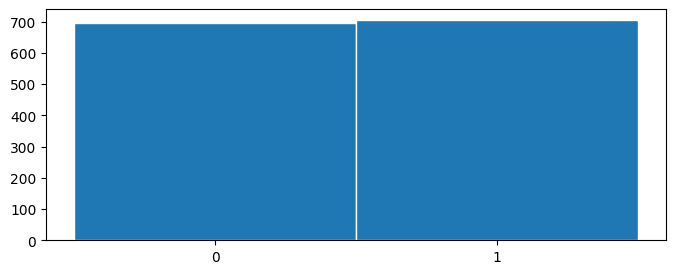

In [25]:
# Distribusi data
col.visualize()

Korelasi terhadap target: -0.010756163737641038


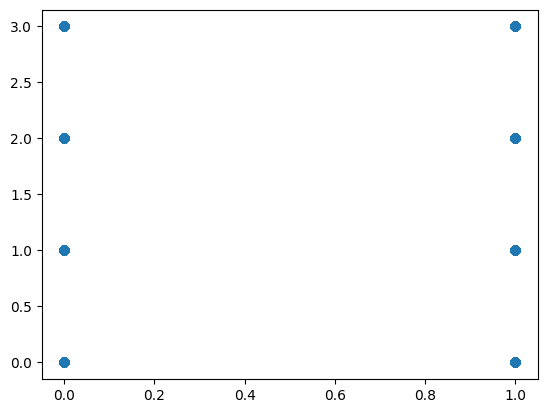

In [26]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Resolusi Kamera Depan (dalam megapixel)

In [27]:
# Statistik dasar
col = NumericStatistics('fc')
col.stats()

,Name,Value
0,Mean,4.275
1,Median,3.000
2,Mode,0.000
3,Standard deviation,4.324
4,Variance,18.698
5,Range,19.000
6,Minimum value,0.000
7,Maximum value,19.000
8,Q1,1.000
9,Q2,3.000


In [28]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 338


In [29]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 11


Kurtosis: 0.29340439238319194


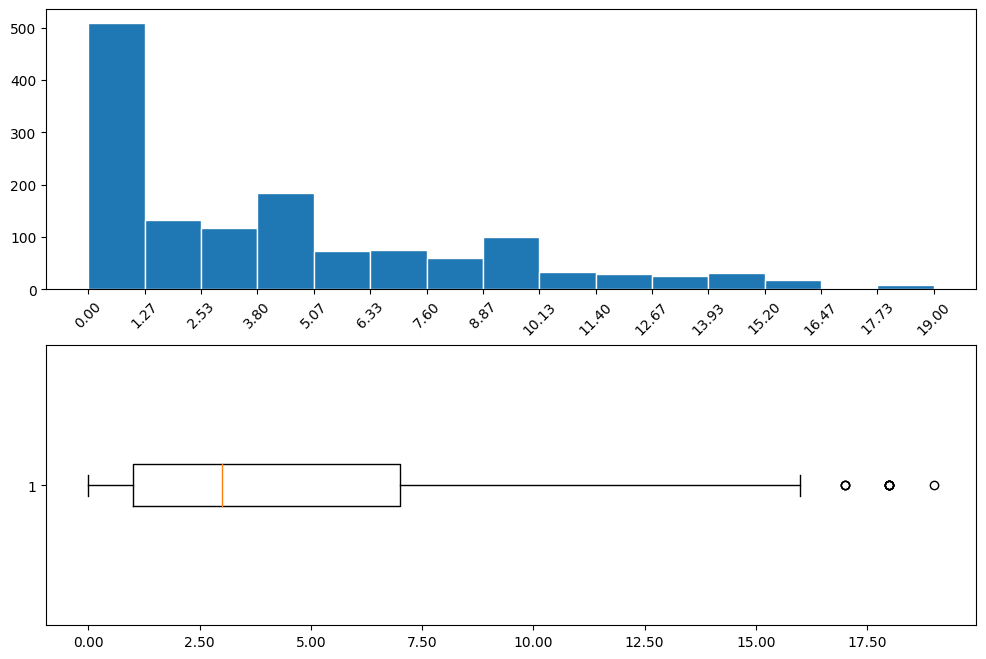

In [30]:
# Distribusi data
col.kurt_analyze()
col.visualize()

Korelasi terhadap target: -0.0038420102981917433


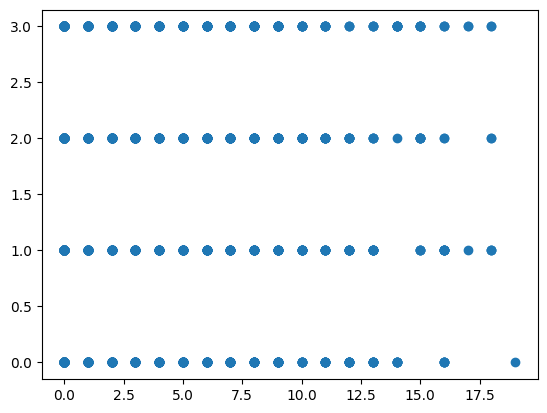

In [31]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### 4G

In [32]:
# Statistik dasar
col = NonnumericStatistics('four_g')
col.stats()

,Name,Value
0,Mean,0.530
1,Median,1.000
2,Mode,1.000
3,Standard deviation,0.499
4,Variance,0.249
5,Range,1.000
6,Minimum value,0.000
7,Maximum value,1.000
8,Q1,0.000
9,Q2,1.000


In [33]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


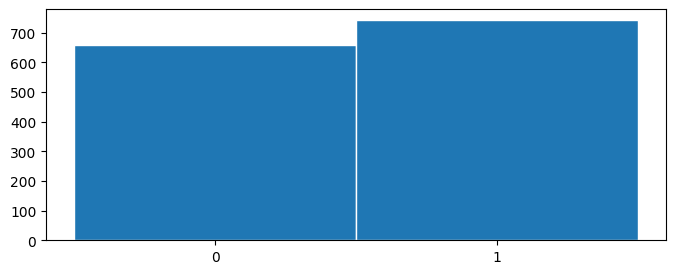

In [34]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.0005508484718002986


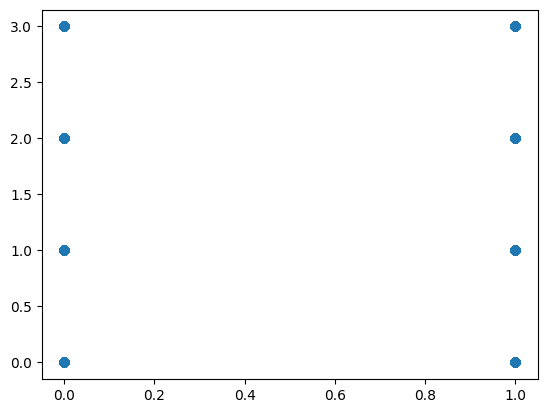

In [35]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Memori Internal (dalam gigabyte)

In [36]:
# Statistik dasar
col = NumericStatistics('int_memory')
col.stats()

,Name,Value
0,Mean,31.962
1,Median,32.000
2,Mode,27.000
3,Standard deviation,18.163
4,Variance,329.893
5,Range,62.000
6,Minimum value,2.000
7,Maximum value,64.000
8,Q1,16.000
9,Q2,32.000


In [37]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [38]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


Kurtosis: -1.22719971066165


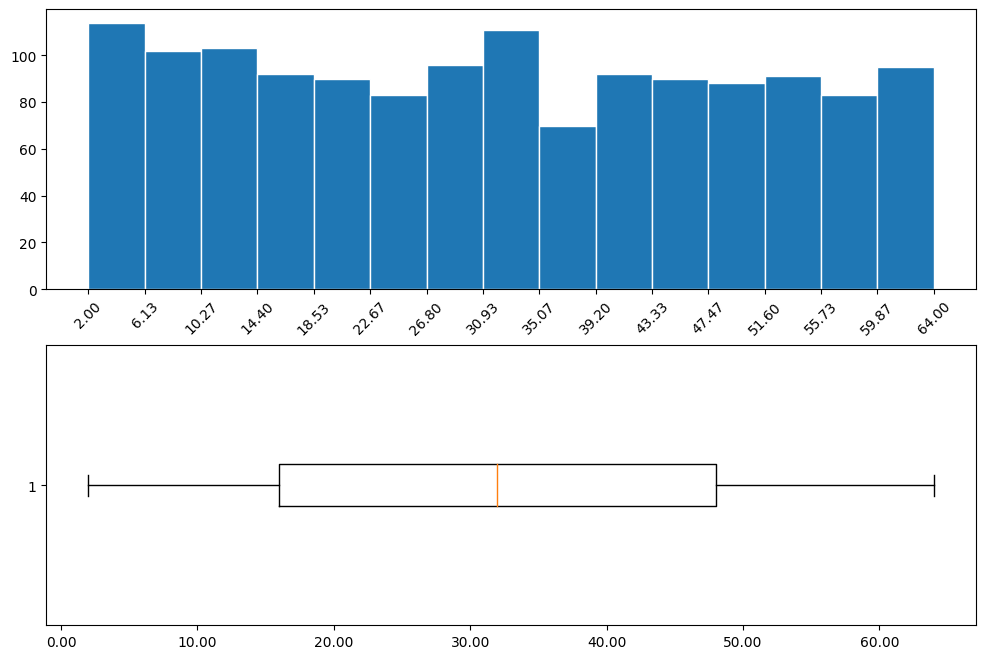

In [39]:
# Distribusi data
col.kurt_analyze()
col.visualize()

Korelasi terhadap target: 0.02617570687784163


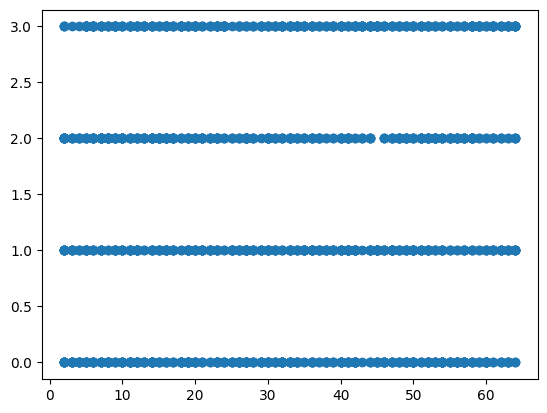

In [40]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Ketebalan Ponsel (dalam cm)

In [41]:
# Statistik dasar
col = NumericStatistics('m_dep')
col.stats()

,Name,Value
0,Mean,0.508
1,Median,0.500
2,Mode,0.100
3,Standard deviation,0.289
4,Variance,0.083
5,Range,0.900
6,Minimum value,0.100
7,Maximum value,1.000
8,Q1,0.200
9,Q2,0.500


In [42]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [43]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


Kurtosis: -1.2668226719440638


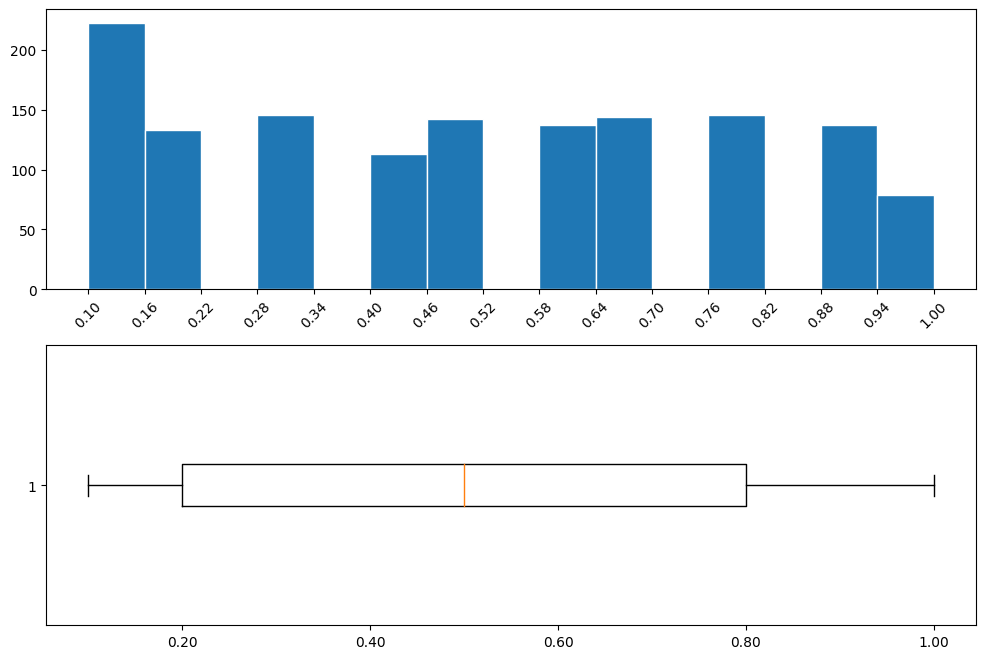

In [44]:
# Distribusi data
col.kurt_analyze()
col.visualize()

Korelasi terhadap target: 0.0012049180209845712


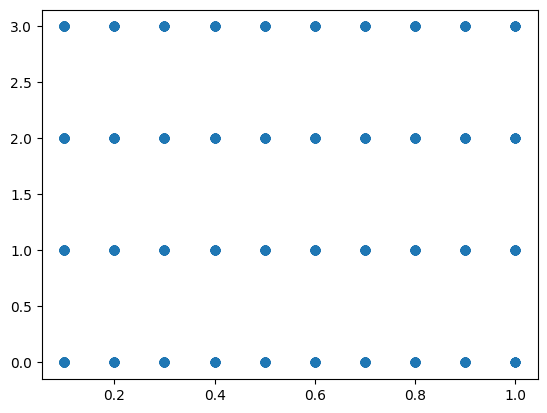

In [45]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Berat Ponsel

In [46]:
# Statistik dasar
col = NumericStatistics('mobile_wt')
col.stats()

,Name,Value
0,Mean,139.376
1,Median,139.000
2,Mode,182.000
3,Standard deviation,35.401
4,Variance,1253.217
5,Range,120.000
6,Minimum value,80.000
7,Maximum value,200.000
8,Q1,108.000
9,Q2,139.000


In [47]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [48]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


Kurtosis: -1.210202007194779


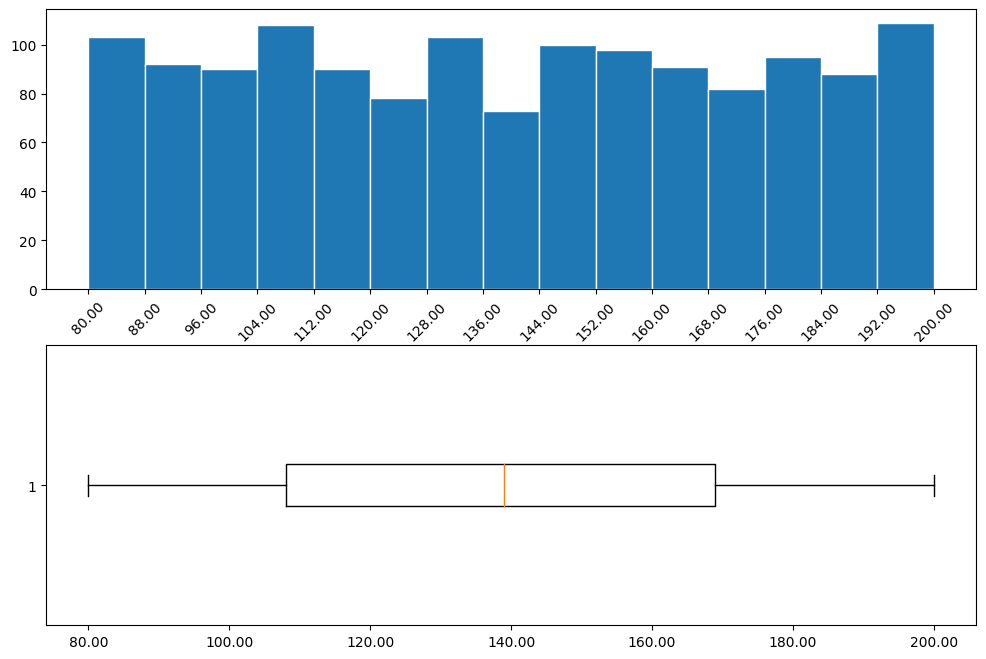

In [49]:
# Distribusi data
col.kurt_analyze()
col.visualize()

Korelasi terhadap target: -0.07476875048323675


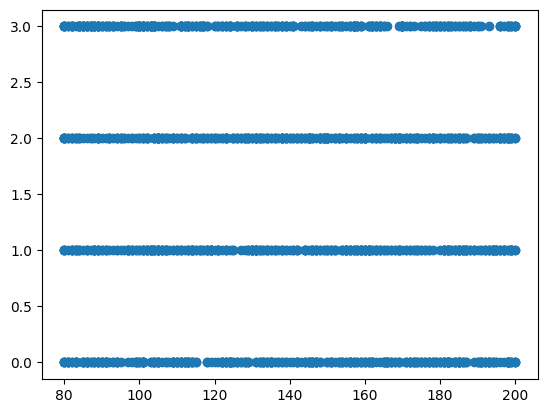

In [50]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Jumlah _core processor_

In [51]:
# Statistik dasar
col = NonnumericStatistics('n_cores')
col.stats()

,Name,Value
0,Mean,4.481
1,Median,4.000
2,Mode,4.000
3,Standard deviation,2.280
4,Variance,5.198
5,Range,7.000
6,Minimum value,1.000
7,Maximum value,8.000
8,Q1,2.000
9,Q2,4.000


In [52]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [53]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


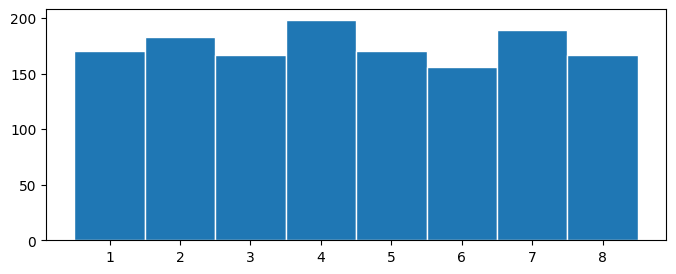

In [54]:
# Distribusi data
col.visualize()

Korelasi terhadap target: -0.0005823306285452556


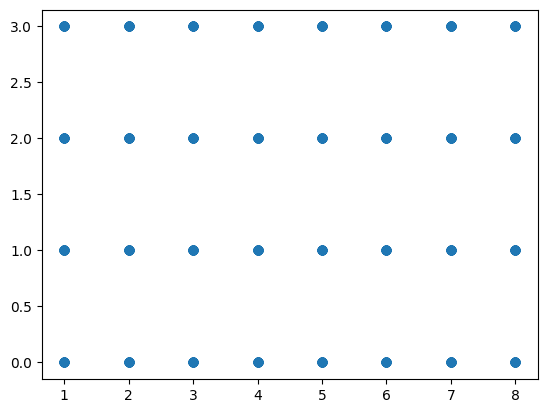

In [55]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Resolusi Kamera Utama dalam Megapixel

In [56]:
# Statistik dasar
col = NumericStatistics('pc')
col.stats()

,Name,Value
0,Mean,9.917
1,Median,10.000
2,Mode,10.000
3,Standard deviation,6.080
4,Variance,36.967
5,Range,20.000
6,Minimum value,0.000
7,Maximum value,20.000
8,Q1,5.000
9,Q2,10.000


In [57]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 70


In [58]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


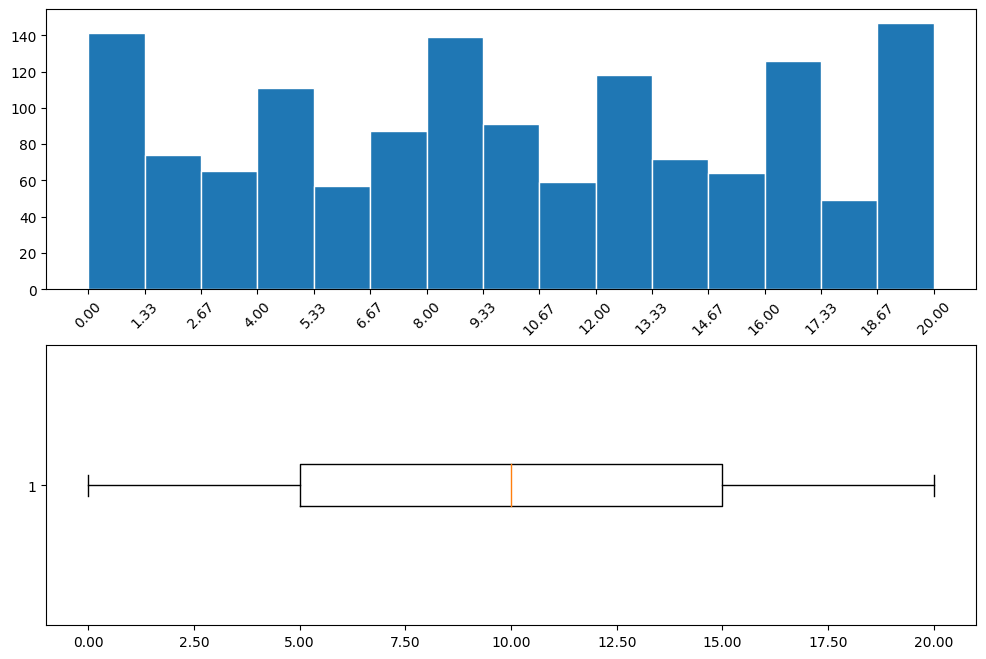

In [59]:
# Distribusi data
col.visualize()

Korelasi terhadap target: -0.005214430491653004


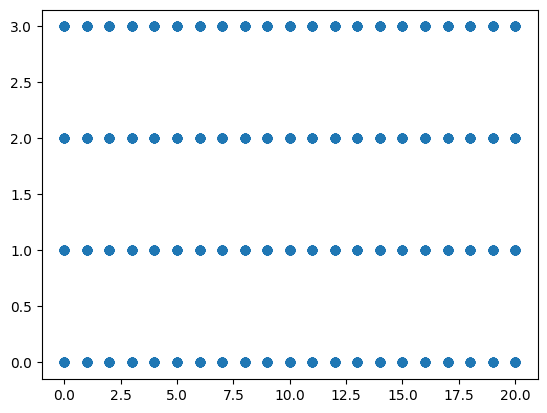

In [60]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Tinggi Resolusi Pixel

In [61]:
# Statistik dasar
col = NumericStatistics('px_height')
col.stats()

,Name,Value
0,Mean,643.178
1,Median,561.000
2,Mode,346.500
3,Standard deviation,444.629
4,Variance,197694.930
5,Range,1960.000
6,Minimum value,0.000
7,Maximum value,1960.000
8,Q1,273.750
9,Q2,561.000


In [62]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 1


In [63]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


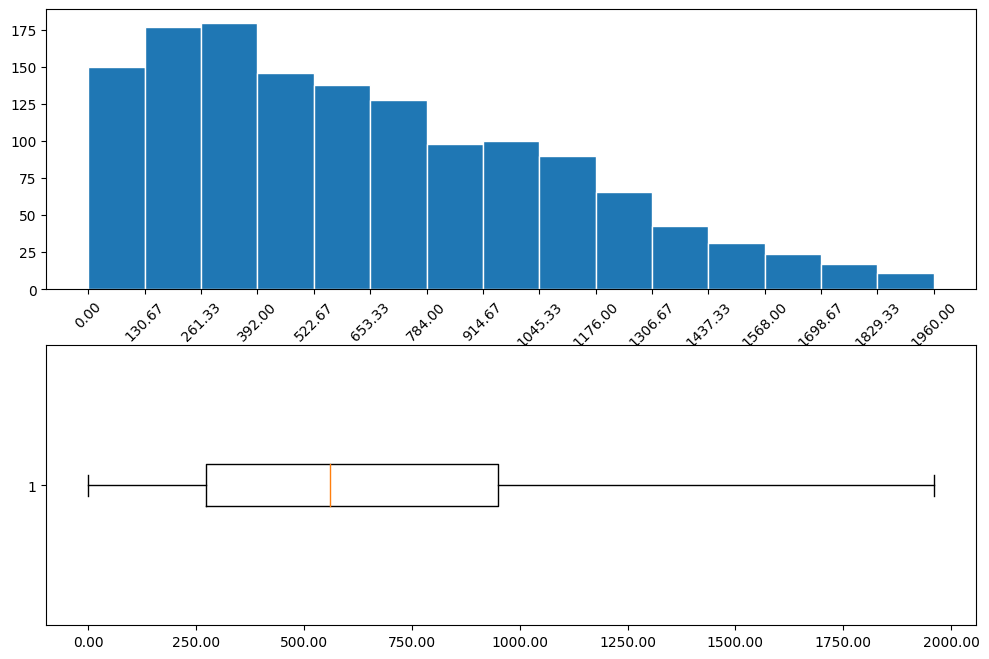

In [64]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.15883273548307994


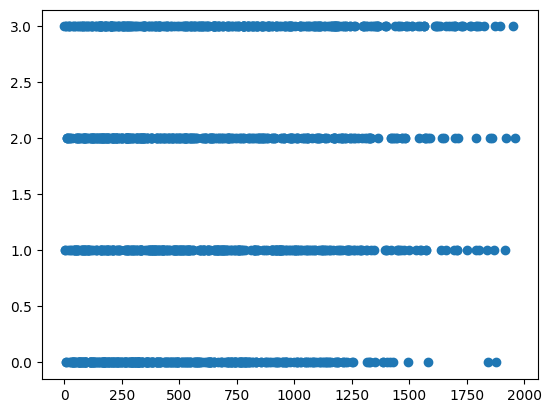

In [65]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Lebar Resolusi Pixel

In [66]:
# Statistik dasar
col = NumericStatistics('px_width')
col.stats()

,Name,Value
0,Mean,1251.717
1,Median,1247.000
2,Mode,1247.000
3,Standard deviation,428.983
4,Variance,184026.286
5,Range,1498.000
6,Minimum value,500.000
7,Maximum value,1998.000
8,Q1,876.500
9,Q2,1247.000


In [67]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [68]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


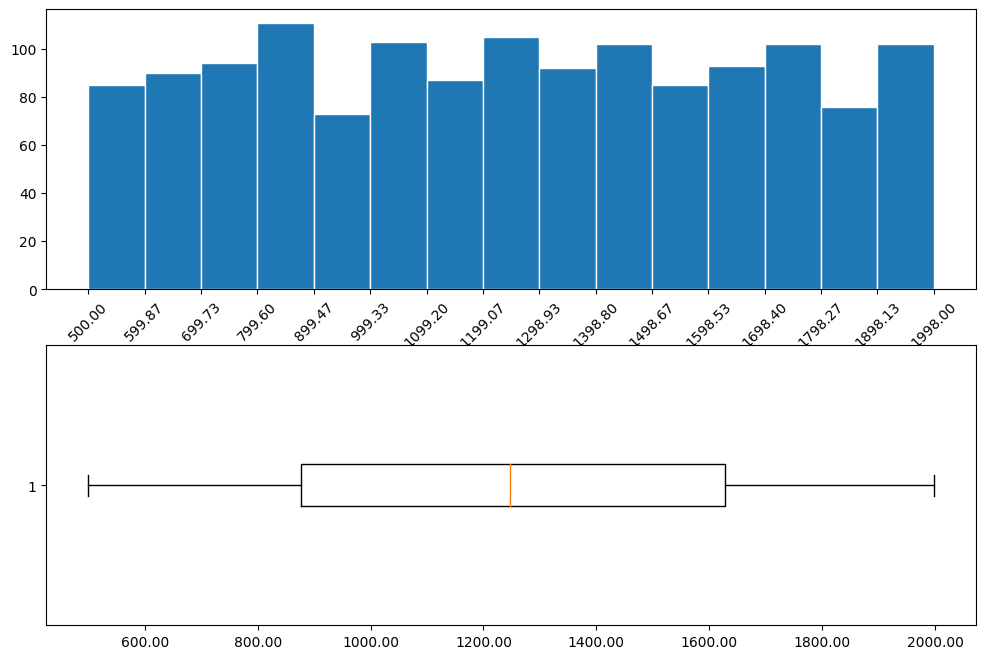

In [69]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.17871269011026594


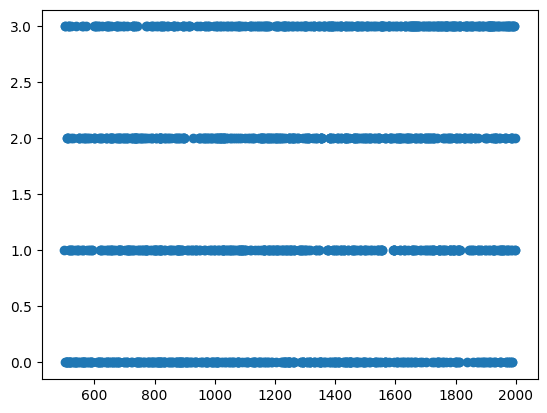

In [70]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Ukuran RAM dalam Megabyte

In [71]:
# Statistik dasar
col = NumericStatistics('ram')
col.stats()

,Name,Value
0,Mean,2.106731e+03
1,Median,2.102000e+03
2,Mode,5.941164e+02
3,Standard deviation,1.078347e+03
4,Variance,1.162833e+06
5,Range,3.742000e+03
6,Minimum value,2.560000e+02
7,Maximum value,3.998000e+03
8,Q1,1.201000e+03
9,Q2,2.102000e+03


In [72]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [73]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


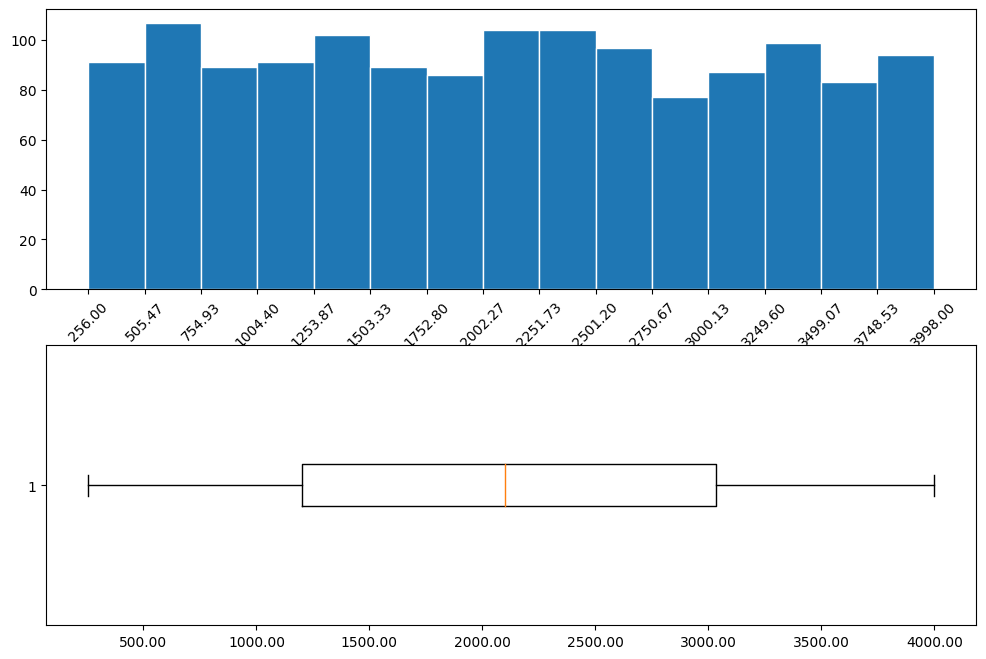

In [74]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.9183192307843853


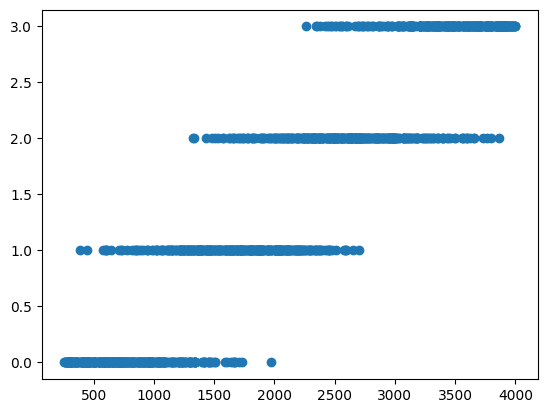

In [75]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Tinggi Layar Ponsel dalam cm

In [76]:
# Statistik dasar
col = NumericStatistics('sc_h')
col.stats()

,Name,Value
0,Mean,12.286
1,Median,12.000
2,Mode,17.000
3,Standard deviation,4.204
4,Variance,17.675
5,Range,14.000
6,Minimum value,5.000
7,Maximum value,19.000
8,Q1,9.000
9,Q2,12.000


In [77]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [78]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


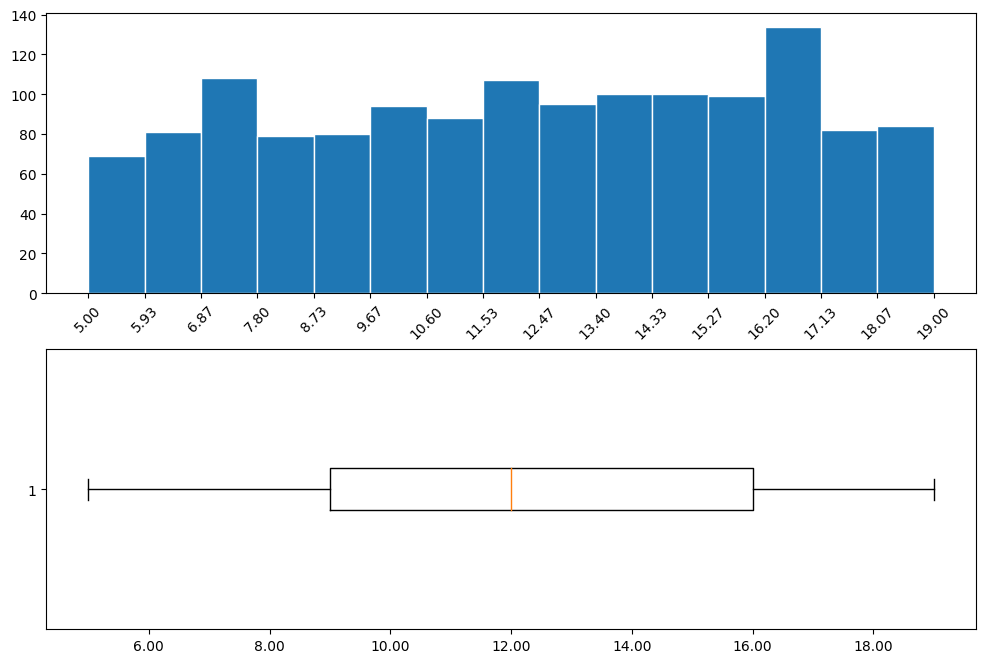

In [79]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.012148883173075014


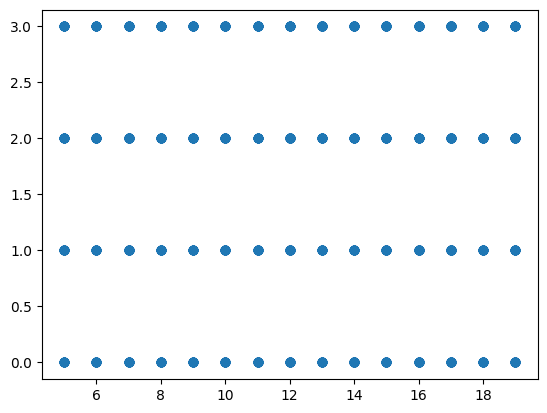

In [80]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Lebar Layar Ponsel dalam cm

In [81]:
# Statistik dasar
col = NumericStatistics('sc_w')
col.stats()

,Name,Value
0,Mean,5.665
1,Median,5.000
2,Mode,1.000
3,Standard deviation,4.372
4,Variance,19.116
5,Range,18.000
6,Minimum value,0.000
7,Maximum value,18.000
8,Q1,2.000
9,Q2,5.000


In [82]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 137


In [83]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


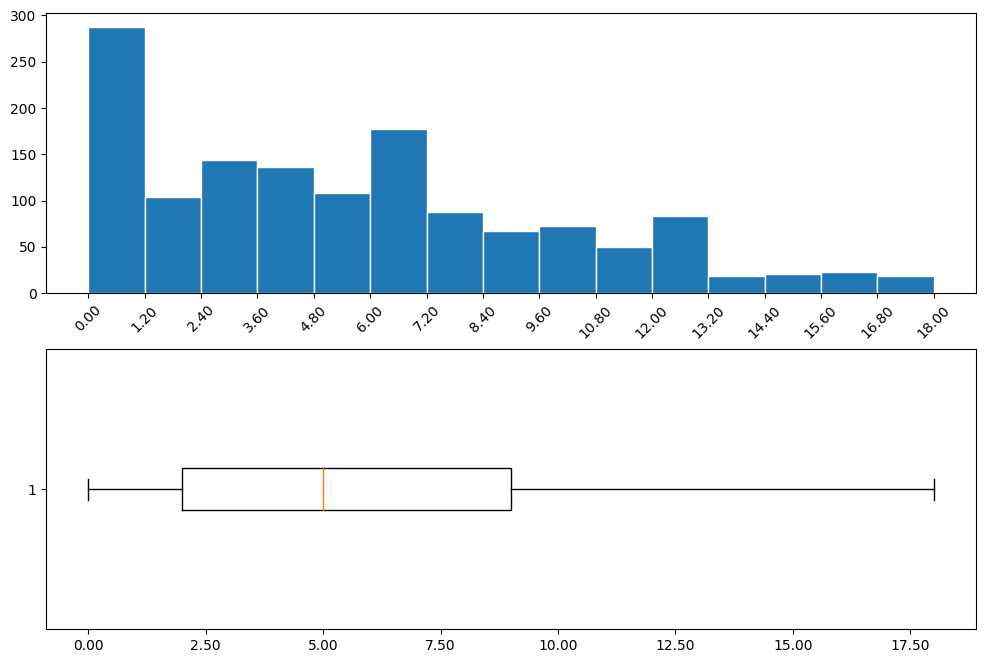

In [84]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.01991169881036506


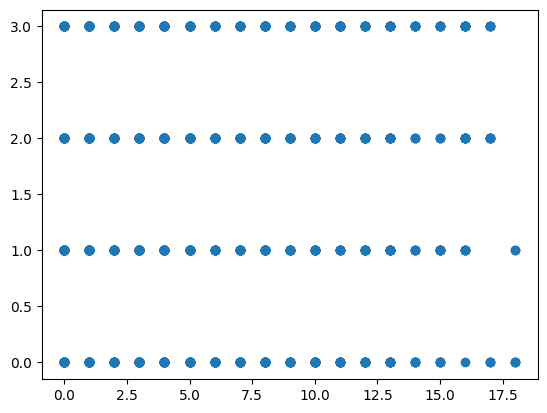

In [85]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Waktu Telepon Maksimum dalam Satu Kali Pengisian Baterai

In [86]:
# Statistik dasar
col = NumericStatistics('talk_time')
col.stats()

,Name,Value
0,Mean,11.042
1,Median,11.000
2,Mode,15.000
3,Standard deviation,5.399
4,Variance,29.150
5,Range,18.000
6,Minimum value,2.000
7,Maximum value,20.000
8,Q1,6.000
9,Q2,11.000


In [87]:
# Missing value
print(f'Missing value: {col.count_zeroes()}')

Missing value: 0


In [88]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


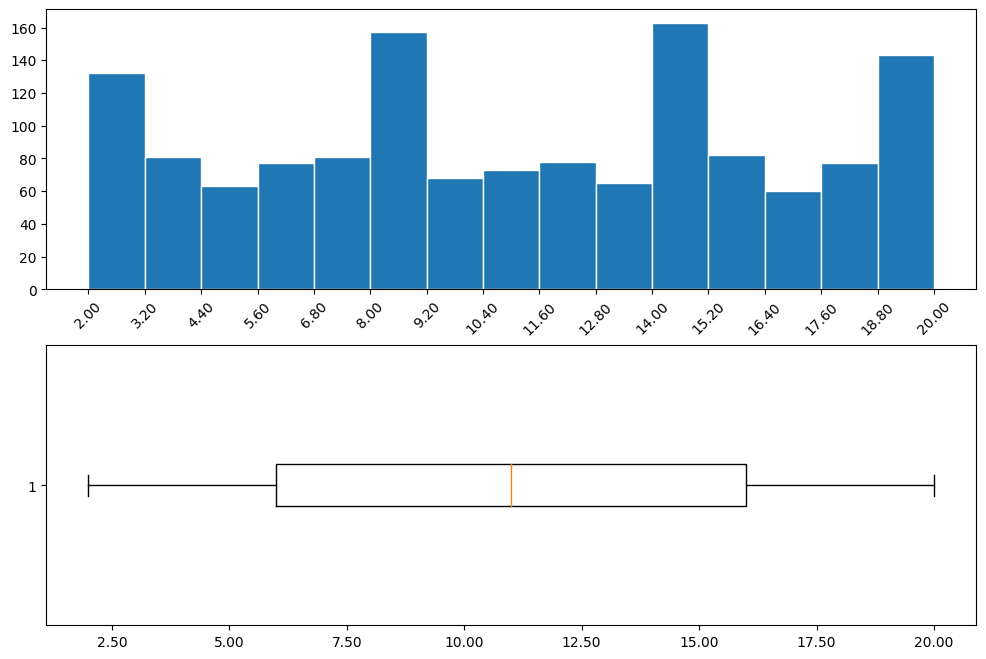

In [89]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.011112731754754954


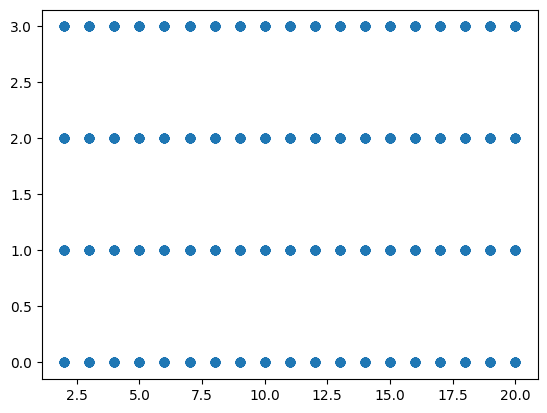

In [90]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Memiliki 3G atau Tidak

In [91]:
# Statistik dasar
col = NonnumericStatistics('three_g')
col.stats()

,Name,Value
0,Mean,0.761
1,Median,1.000
2,Mode,1.000
3,Standard deviation,0.427
4,Variance,0.182
5,Range,1.000
6,Minimum value,0.000
7,Maximum value,1.000
8,Q1,1.000
9,Q2,1.000


In [92]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 335


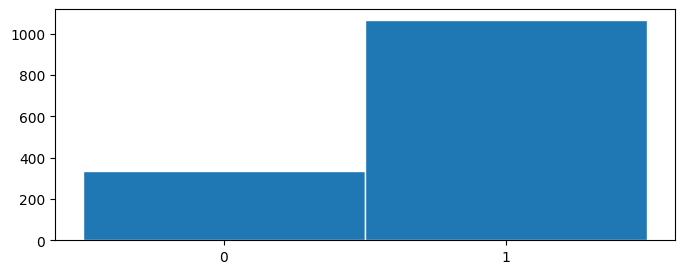

In [93]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.02709762831217486


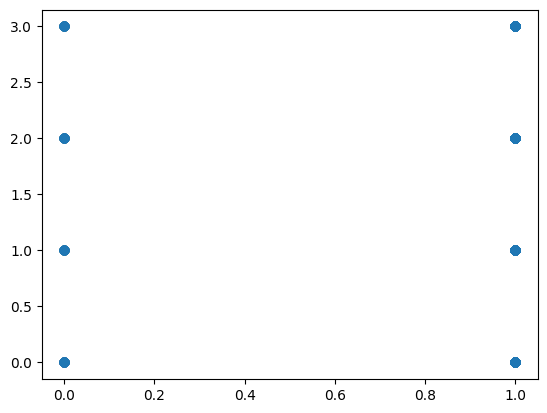

In [94]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Memiliki Layar Sentuh atau Tidak

In [95]:
# Statistik dasar
col = NonnumericStatistics('touch_screen')
col.stats()

,Name,Value
0,Mean,0.489
1,Median,0.000
2,Mode,0.000
3,Standard deviation,0.500
4,Variance,0.250
5,Range,1.000
6,Minimum value,0.000
7,Maximum value,1.000
8,Q1,0.000
9,Q2,0.000


In [96]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


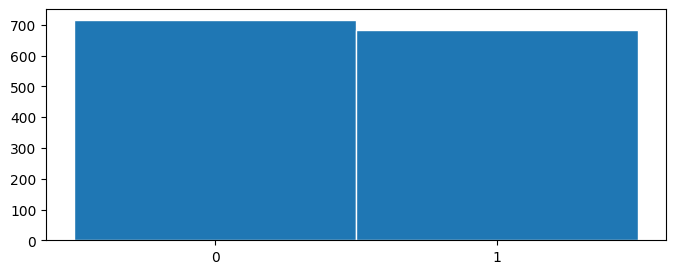

In [97]:
# Distribusi data
col.visualize()

Korelasi terhadap target: -0.029842480103711932


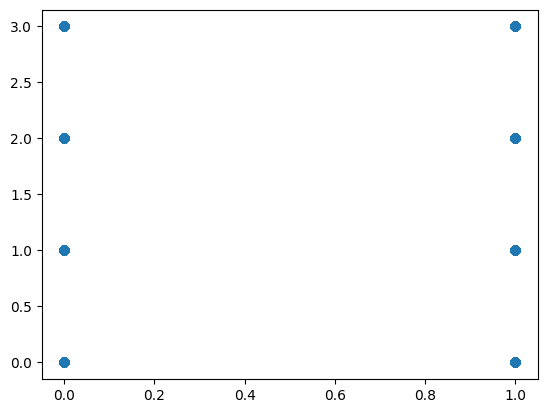

In [98]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')

### Memiliki Wifi atau Tidak

In [99]:
# Statistik dasar
col = NonnumericStatistics('wifi')
col.stats()

,Name,Value
0,Mean,0.495
1,Median,0.000
2,Mode,0.000
3,Standard deviation,0.500
4,Variance,0.250
5,Range,1.000
6,Minimum value,0.000
7,Maximum value,1.000
8,Q1,0.000
9,Q2,0.000


In [100]:
# Outlier
print(f'Outlier count: {col.count_outliers()}')

Outlier count: 0


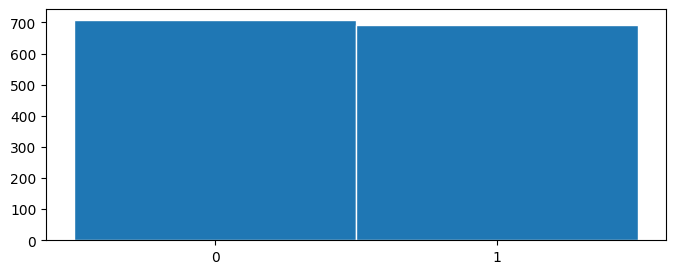

In [101]:
# Distribusi data
col.visualize()

Korelasi terhadap target: 0.03432935762117301


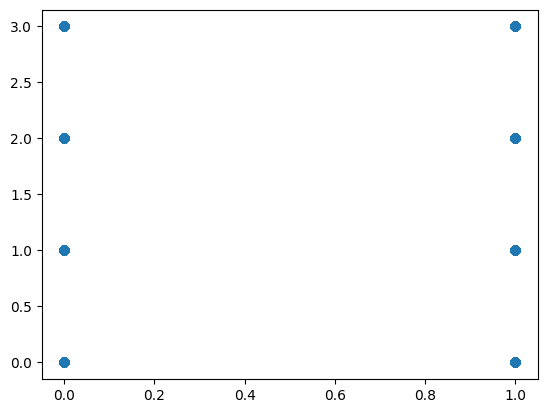

In [102]:
# Korelasi terhadap kolom target
corr, _ = col.versus(data['price_range'])
print(f'Korelasi terhadap target: {corr}')